In [1]:
%matplotlib inline

from matplotlib import rc
from fourierPSF.fourierModel import *
from fourierPSF.FourierUtils import *

from mavis import *

rc("text", usetex=False)

In [2]:
def overallSimulation(path, parametersFile, windPsdFile, outputDir, outputFile, hh=0):
    fullPathFilename = path + parametersFile + '.ini'    
    parser = ConfigParser()
    parser.read(fullPathFilename);
    wvl = eval(parser.get('PSF_DIRECTIONS', 'ScienceWavelength'))[0]  # lambda
    pixel_psf = eval(parser.get('PSF_DIRECTIONS', 'psInMas'))

    tel_diameter = eval(parser.get('telescope', 'TelescopeDiameter'))
    tel_radius = tel_diameter/2  # mas

    LO_zen = eval(parser.get('SENSOR_LO', 'GuideStarZenith_LO')) 
    LO_az = eval(parser.get('SENSOR_LO', 'GuideStarAzimuth_LO'))
    fluxes = eval(parser.get('SENSOR_LO', 'nph_LO'))
    fr = eval(parser.get('SENSOR_LO', 'SensorFrameRate_LO'))
    polarNGSCoordsList = [[LO_zen[0],LO_az[0]], [LO_zen[1],LO_az[1]],[LO_zen[2],LO_az[2]]]
    NGS_flux = [fluxes[0]*fr, fluxes[1]*fr, fluxes[2]*fr]
    polarNGSCoords = np.asarray(polarNGSCoordsList)
    # gridElements = 5
    # xxPointigsV , yyPointigsV =  np.linspace(-15, 15, gridElements), np.linspace(-15,15, gridElements) 
    zenithSrc      = np.array(eval(parser.get('PSF_DIRECTIONS', 'ScienceZenith')))
    azimuthSrc     = np.array(eval(parser.get('PSF_DIRECTIONS', 'ScienceAzimuth')))
    pp = polarToCartesian(np.array( [zenithSrc, azimuthSrc]))
    xxPointigs = pp[0,:]
    yyPointigs = pp[1,:]
    # xxPointigs, yyPointigs = np.meshgrid(xxPointigsV , yyPointigsV)
    fao = fourierModel(fullPathFilename, calcPSF=False, verbose=False, display=False, \
                   cartPointingCoords=np.array([xxPointigs, yyPointigs]).transpose() , extraPSFsDirections=polarNGSCoordsList)
    PSD = fao.powerSpectrumDensity()
    PSD = PSD.transpose()
    N = PSD[0].shape[0]    
    freq_range = fao.fovInPixel*fao.PSDstep # fao.psf_FoV/fao.wvlRef/206264.8
    pitch = 1/freq_range
    grid_diameter = pitch*N
    scaleFactor = (2*np.pi*1e-9/wvl)**2
    dk = 2*fao.kc/fao.resAO * 1e9
    mask = Field(wvl, N, pitch*N)
    print(tel_diameter/pitch)
    sx = int(tel_diameter/pitch)+hh
    
    mask.sampling = cp.asarray(congrid(fao.tel.pupil, [sx, sx]))
    mask.sampling = zeroPad(mask.sampling, (N-sx)//2)
    
    print('fao.samp:', fao.samp)

    def psdSetToPsfSet(inputPSDs):
        NGS_SR_1650 = []
        psdArray = []
        psfLongExpArr = []
        NGS_FWHM_mas = []
        for computedPSD in inputPSDs:    
            psd = Field(wvl, N, freq_range, 'rad')
            psd.sampling = cp.asarray(computedPSD / dk**2 )
            psfLongExp = longExposurePsf(mask, psd )
            scaledSampling = computedPSD * scaleFactor
            sr1 = np.exp(-scaledSampling.sum())
            print('sr1:', sr1)
            sr2 = getStrehl( cp.asnumpy(psfLongExp.sampling), fao.tel.pupil, fao.samp)
            print('sr2:', sr2)
            fw1 = np.hypot(psfLongExp.FWHM()[0],psfLongExp.FWHM()[1]) * 180 / np.pi * 3600 * 1000
            print('fw1:', fw1)
            fw2 =  getFWHM( cp.asnumpy(psfLongExp.sampling), psfLongExp.pixel_size, method='contour', nargout=1) * 180 / np.pi * 3600 * 1000
            print('fw2:', fw2)            
            NGS_SR_1650.append(sr2)
            psdArray.append(psd)
            psfLongExpArr.append(psfLongExp)
            NGS_FWHM_mas.append(fw2)

        return NGS_SR_1650, psdArray, psfLongExpArr, NGS_FWHM_mas

    NGS_SR_1650, psdArray, psfLongExpArr, NGS_FWHM_mas = psdSetToPsfSet(PSD[-3:])
        
    cartPointingCoords =  np.dstack( (xxPointigs, yyPointigs) ).reshape(-1, 2)
    cartNGSCoords = np.asarray([polarToCartesian(polarNGSCoords[0,:]), polarToCartesian(polarNGSCoords[1,:]), polarToCartesian(polarNGSCoords[2,:])])
    mLO = MavisLO(path, parametersFile, windPsdFile)
    Ctot = mLO.computeTotalResidualMatrix(np.array(cartPointingCoords), cartNGSCoords, NGS_flux, NGS_SR_1650, NGS_FWHM_mas)
    cov_ellipses = mLO.ellipsesFromCovMats(Ctot)
    
    pointings_SR_1650, psdPointingsArray, psfLongExpPointingsArr, pointings_FWHM_mas = psdSetToPsfSet(PSD[:-3])
    
    results = []
    for ellp, psfLongExp in zip(cov_ellipses, psfLongExpPointingsArr):
        results.append(convolve(psfLongExp, residualToSpectrum(ellp, wvl, N, fao.psf_FoV*fao.psInMas)))

    psfLongExpPointingsArr[0].standardPlot(True)
    results[0].standardPlot(True)

    plotEllipses(cartPointingCoords, cov_ellipses, 0.2)
    tiledDispaly(results)

    # save PSF cube in fits    
    hdul1 = fits.HDUList()
    cube =[]
    hdul1.append(fits.PrimaryHDU())
    for img in results:
        cube.append(cp.asnumpy(img.sampling))
        
    hdul1.append(fits.ImageHDU(data=np.array(cube)))
    hdul1.writeto( outputDir + outputFile + '.fits')

320.17498865456446
fao.samp: 1.0
sr1: 0.03339209764858256
sr2: 0.428557377671423
fw1: 15.93740398502606
fw2: 16.51262965563763
sr1: 0.016558536857690067
sr2: 0.36132304136706783
fw1: 16.012466827532354
fw2: 16.524868453568722
sr1: 0.014287141672181349
sr2: 0.3511448344214844
fw1: 16.060568058025247
fw2: 16.57067673635368
sr1: 0.08476903653994516
sr2: 0.538233116725676
fw1: 15.906154484577835
fw2: 16.489150645184576
sr1: 0.07559482700769521
sr2: 0.5228225854288128
fw1: 15.878848600478047
fw2: 16.480403933648834
sr1: 0.08236781639437238
sr2: 0.5328320059405424
fw1: 15.82068262393584
fw2: 16.463197888836433
sr1: 0.10242881321813571
sr2: 0.5614931939370296
fw1: 15.799066056117784
fw2: 16.453758519615672
sr1: 0.06630085609744585
sr2: 0.5063447514072712
fw1: 15.88185967457053
fw2: 16.482518496003085
sr1: 0.06921095100602447
sr2: 0.5108882917731906
fw1: 15.852873997026856
fw2: 16.467334601025623
sr1: 0.08195016057731794
sr2: 0.5314709698871869
fw1: 15.804116739599264
fw2: 16.450205612870647
s

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


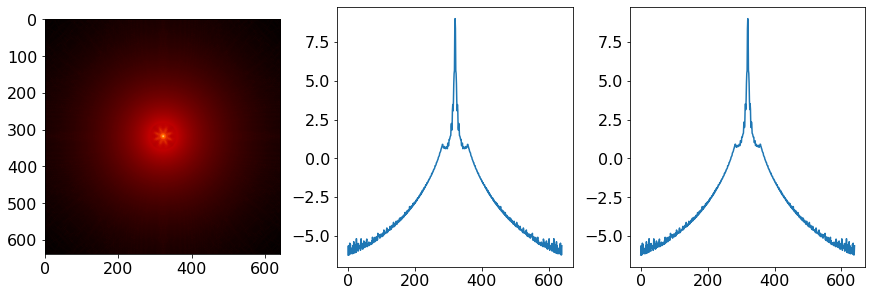

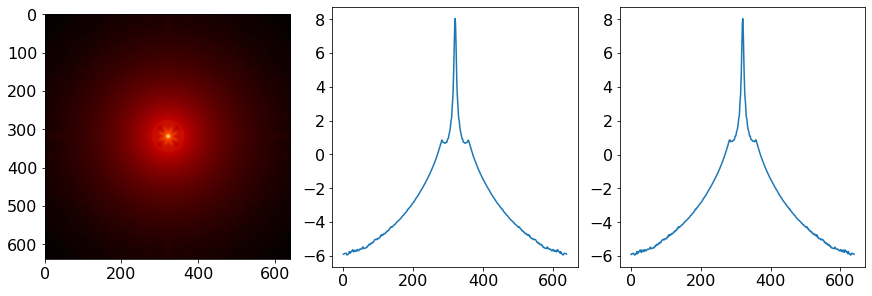

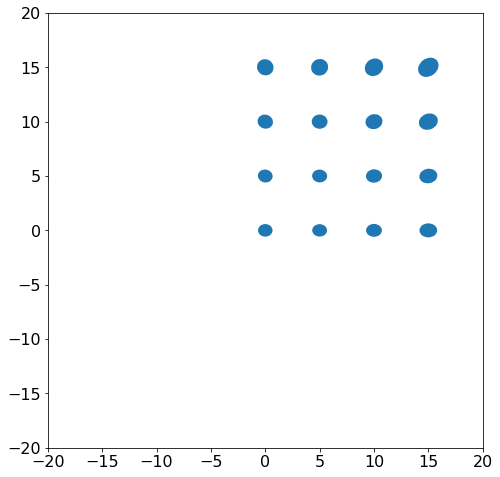

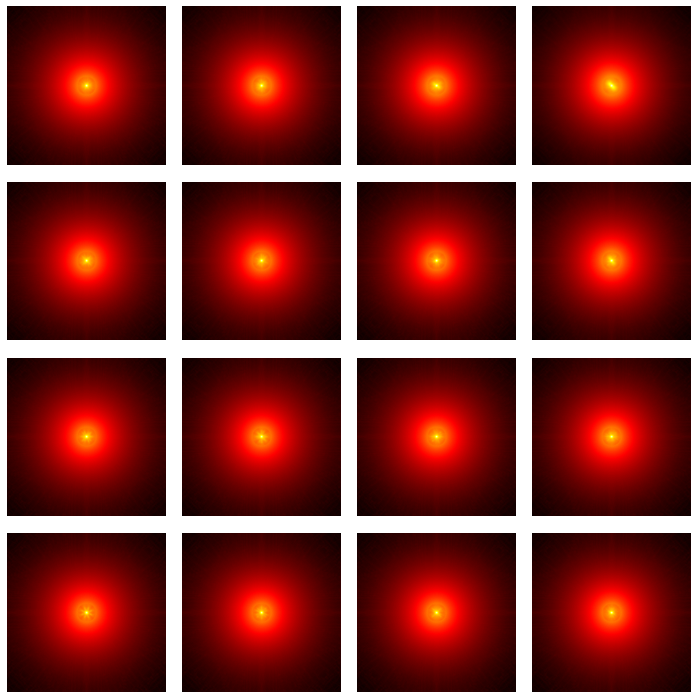

OSError: File '/data4/frossi/simulation450nm.fits' already exists.

In [3]:
baseInputPath = '/data7/guido/results/MAVIS/res4psf/20201116_111006.0_oaPSFs_w'
baseOutpuPath = '/data4/frossi/'
windPsdFile = 'data/windpsd_mavis.fits'

wvlPaths = ['450', '550', '640', '890']
for wvlPath in wvlPaths:
    fullInputPath = baseInputPath + wvlPath + 'nm/'
    parametersFile = 'params'
    outputFile = 'simulation' + wvlPath + 'nm'
    overallSimulation(fullInputPath, parametersFile, windPsdFile, baseOutpuPath, outputFile)

In [ ]:
path = "/home/frossi/dev/MASTSEL/"
parametersFile = 'mavisParams'
windPsdFile = 'data/windpsd_mavis.fits'
baseOutpuPath = '/data4/frossi/'

overallSimulation(path, parametersFile, windPsdFile, baseOutpuPath, "test", hh=0)

In [ ]:
# NGS_flux = [10000, 30000, 5000]
# old values: NGS_SR_1650 = [0.4, 0.2, 0.6]
# old values: NGS_FWHM_mas = [90, 110, 85]